In [15]:
import pandas as pd
import math
import time
import torch

from dataloading import *
from model import *

In [16]:
def train(model, inputs, targets, optimizer, criterion, computing_device, config):
    model = model.to(computing_device)
    model.train()
    epoch_loss = 0
    
    for i in range(len(targets)):
        
        src = inputs[i].to(computing_device)
        trg = targets[i].to(computing_device)
        
        optimizer.zero_grad()
        
        outputs = model(src, trg, teacher_forcing_ratio=config['teacher_forcing_ratio'])
        
        labels = torch.argmax(trg, dim=2) # grab indices for loss function
        
        #targets = [trg sent len, batch size]
        #outputs = [trg sent len, batch size, output dim]
        
        #print('expected')
        #print(src.size())
        #print(labels)
        #print(torch.argmax(outputs, dim=2))
        
        outputs = outputs.view(-1, outputs.shape[-1]) 
        labels = labels.view(-1)
        
        outputs = outputs.to(computing_device)
        
        #targets = [(trg sent len - 1) * batch size]- trg should be list of indicies
        #outputs = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(targets)

def validate(model, inputs, targets, optimizer, criterion, computing_device):
    model=model.to(computing_device)
    model.eval()
    total_loss=0.0
    
    with torch.no_grad():   
        for i in range(len(targets)):
                src = inputs[i].to(computing_device)
                trg = targets[i].to(computing_device)

                #print(len(src))
                #print(len(trg))

                #optimizer.zero_grad()

                outputs = model(src, trg, teacher_forcing_ratio=0.0)

                labels = torch.argmax(trg, dim=2) # grab indices for loss function

                outputs = outputs.view(-1, outputs.shape[-1]) 
                labels = labels.view(-1)

                outputs = outputs.to(computing_device)

                loss = criterion(outputs, labels)
                total_loss+=loss.item()

                #print('expected')
                #print(trg.size())
                #print(torch.argmax(trg, dim=2))
                #print(torch.argmax(outputs, dim=2))

                #num_labels = interpret_output(trg)
                #num_predictions = interpret_output(outputs)



                # shape = [seq_len, batch_size]
                #mse = mean_squared_error(num_labels,num_predictions)
                #print('MSE',mse)
            
    #total_mse/=len(targets)
    #print(total_mse)
    #print(len(targets))
    return total_loss/len(targets)

print('done')

done


In [17]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")
 
computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = {
    'batch_size':512,
    'learning_rate':0.001,
    'weight_decay':0,
    'teacher_forcing_ratio':1.0,
    'hidden_dim':512,
    'n_layers':4, 
    'enc': {
        'hid_dropout':0.0,
        'input_dropout':0.0
    },
    'dec': {
        'hid_dropout':0.0,
        'input_dropout':0.0
    }
}

n_digits = 10
#OUTPUT_DIM = n_digits + 2
n_chars=256
INPUT_DIM = n_chars+4
OUTPUT_DIM = n_digits + 5
#ENC_EMB_DIM = n_chars+1
#DEC_EMB_DIM = OUTPUT_DIM

HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.0
DEC_DROPOUT = 0.0
device=None

#enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
#dec = Decoder(OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

enc = Encoder(INPUT_DIM, config['hidden_dim'], config['n_layers'], config['enc']['hid_dropout'], config['enc']['input_dropout'])
dec = Decoder(OUTPUT_DIM, config['hidden_dim'], config['n_layers'], config['dec']['hid_dropout'], config['dec']['input_dropout'])

model = Seq2Seq(enc, dec,computing_device)#.to(device)

optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'],weight_decay=config['weight_decay'])
criterion = nn.CrossEntropyLoss(ignore_index=output_pad_index)

print('done')

CUDA is supported
done


In [18]:
import os

data_dir = 'data/numerical_data_set_simple_torch'

filenames = []
filenames_by_type = {'A':[], 'B':[], 'C':[], 'D':[], 'E':[]}
for file in os.listdir(data_dir):
    filename, file_extension = os.path.splitext(file)
    
    typ = filename[-1]
    if typ in filenames_by_type:
        filenames.append(file)
        filenames_by_type[typ].append(file)
        
print(len(filenames))
print(filenames_by_type)
for key in filenames_by_type:
    print(len(filenames_by_type[key]))

27
{'A': ['labelled_gen_data1_A', 'labelled_gen_data3_A', 'labelled_gen_data2_A', 'labelled_extr_data1_A', 'labelled_extr_data3_A'], 'B': ['labelled_extr_data19_B', 'labelled_extr_data18_B', 'labelled_gen_data5_B', 'labelled_gen_data4_B', 'labelled_gen_data6_B'], 'C': ['labelled_gen_data10_C', 'labelled_gen_data11_C', 'labelled_gen_data7_C', 'labelled_gen_data8_C', 'labelled_gen_data9_C'], 'D': ['labelled_extr_data2_D', 'labelled_gen_data12_D', 'labelled_gen_data13_D', 'labelled_extr_data4_D'], 'E': ['labelled_extr_data20_E', 'labelled_gen_data16_E', 'labelled_dir_data91_E', 'labelled_gen_data15_E', 'labelled_dir_data92_E', 'labelled_gen_data14_E', 'labelled_dir_data39_E', 'labelled_dir_data49_E']}
5
5
5
4
8


In [19]:


'''
df = pd.DataFrame({'Attribute_value':[], 'Numerical_value':[]})
for filename in filenames_by_type['E'][:-1]:
    print(filename)
    dfE = pd.read_csv(os.path.join(data_dir,filename))
    #dfE[['Attribute_value','Numerical_Value']]
    df = pd.concat([df,dfE[['Attribute_value','Numerical_value']]])
    print(len(df))

                 
#df = pd.read_csv(os.path.join(data_dir,filenames[0])

inputs = df['Attribute_value']
targets = df['Numerical_value']
'''
data_dir = 'data/numerical_data_set_simple_torch'

start=time.time()
filename=filenames_by_type['E'][0]
q = torch.load(os.path.join(data_dir,filename))
inputs,targets = q[0],q[1]

for filename in filenames_by_type['E'][1:-1]:
    q = torch.load(os.path.join(data_dir,filename))
    src,trg = q[0],q[1]
    print(src.size())
    print(trg.size())
    inputs=torch.cat([inputs,src],dim=1)
    targets=torch.cat([targets,trg],dim=1)

filename=filenames_by_type['E'][-1]
q = torch.load(os.path.join(data_dir,filename))
val_inputs,val_targets = q[0],q[1]
        

BATCH_SIZE=config['batch_size']
n_chunks = math.ceil(inputs.size()[1]/BATCH_SIZE)
val_n_chunks = math.ceil(val_inputs.size()[1]/BATCH_SIZE)

#inputs = prepare_data(inputs)
#targets = prepare_targets(targets)
print(time.time()-start)
print('done prepare')

print((inputs).size())
print((targets).size())

#print('input')
#print(inputs[:,0,:])
#print('target')
#print(targets[:,0,:])
#print(torch.argmax(targets, dim=2)[:,0])

start=time.time()
inputs = torch.chunk(inputs, n_chunks, dim=1) 
targets = torch.chunk(targets, n_chunks, dim=1) 

val_inputs = torch.chunk(val_inputs, val_n_chunks, dim=1) 
val_targets = torch.chunk(val_targets, val_n_chunks, dim=1) 

print('done chunking')
print(time.time()-start)
print(BATCH_SIZE)
print(n_chunks)
print(len(inputs))
print((inputs[0].size()))
print((targets[0].size()))

#print((inputs[3].size()))
#print((targets[3].size()))

print('done')



torch.Size([24, 75465, 260])
torch.Size([24, 75465, 15])
torch.Size([24, 7787, 260])
torch.Size([24, 7787, 15])
torch.Size([24, 75465, 260])
torch.Size([24, 75465, 15])
torch.Size([24, 7787, 260])
torch.Size([24, 7787, 15])
torch.Size([24, 75465, 260])
torch.Size([24, 75465, 15])
torch.Size([24, 41544, 260])
torch.Size([24, 41544, 15])
18.70589828491211
done prepare
torch.Size([24, 289764, 260])
torch.Size([24, 289764, 15])
done chunking
0.013660192489624023
512
566
566
torch.Size([24, 512, 260])
torch.Size([24, 512, 15])
done


In [ ]:
num_epochs = 100
train_losses =[]
val_losses=[]

for epoch in range(num_epochs):
    print('epoch', epoch)
    start=time.time()
    loss = train(model, inputs, targets, optimizer, criterion, computing_device, config)
    val_loss = validate(model, val_inputs, val_targets, optimizer, criterion, computing_device)
    train_losses.append(loss)
    val_losses.append(val_loss)
    print('time',time.time()-start)
    print('train_loss',loss)
    print('val_loss',val_loss)

epoch 0
time 108.6315815448761
train_loss 1.9030769102986205
val_loss 2.7634001010801734
epoch 1
time 104.51639533042908
train_loss 1.9354568153303842
val_loss 2.800645773003741
epoch 2
time 104.80994462966919
train_loss 1.9310220368338136
val_loss 2.8748545762969226
epoch 3
time 104.63588500022888
train_loss 1.9329898991348886
val_loss 2.8392544345157904
epoch 4
time 104.57518076896667
train_loss 1.905427571109664
val_loss 2.919621781605046
epoch 5
time 104.64498257637024
train_loss 1.8937171604945044
val_loss 2.779867922387472
epoch 6
time 104.54420733451843
train_loss 1.921595547098153
val_loss 2.8579906719486887
epoch 7


In [18]:
PATH = "./output/typeE_9.pt"
torch.save(model.state_dict(), PATH)

In [ ]:
from matplotlib import pyplot as plt


y = [1.7883344169384168,1.8470590526675001,1.7315473764398952,1.4765218209337305,0.9203645781510406,0.5513821186750759,0.429654762516787,0.3873074577638396,0.3724944071361312]
x = list(range(len(y)))

plt.plot(x,y)
plt.xlabel('epochs')
plt.ylabel('cross entropy')
plt.title('Training on type E, hid_dim=512, num_layers=2')
plt.show()

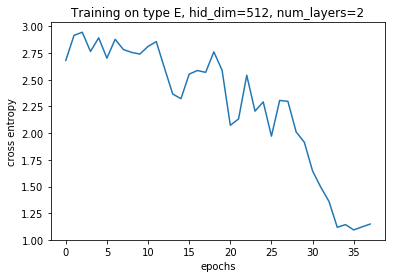

[2.8396030286463296, 2.771896608864389, 2.5931823157682654, 2.6113925395942315, 2.249573165032922, 2.1006960412351097, 1.3531080326656018, 1.1224431868006544]
[0, 5, 10, 15, 20, 25, 30, 35]


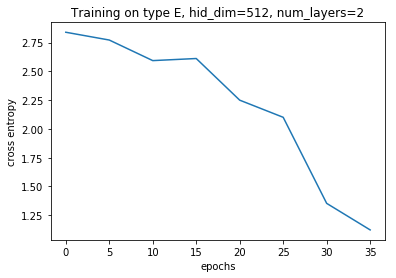

[2.8396030286463296, 2.7894274566231707, 2.558319972201091, 2.2291973398952947, 1.6856641269311674, 1.1224431868006544]
[0, 7, 14, 21, 28, 35]


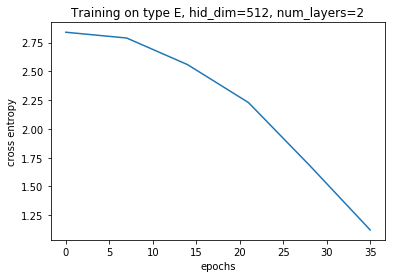

In [13]:
from matplotlib import pyplot as plt
import numpy as np

x = list(range(len(val_losses)))

plt.plot(x,val_losses)
plt.xlabel('epochs')
plt.ylabel('cross entropy')
plt.title('Training on type E, hid_dim=512, num_layers=2')
plt.show()



losses = []
BATCH=5
for i in range(0,len(val_losses),BATCH):
    hi = min(i+5,len(val_losses))
    losses.append(np.mean(val_losses[i:hi]))
    
x = list(range(0,len(val_losses),BATCH))

print(losses)
print(x)

plt.plot(x,losses)
plt.xlabel('epochs')
plt.ylabel('cross entropy')
plt.title('Training on type E, hid_dim=512, num_layers=2')
plt.show()

losses = []
BATCH=7
for i in range(0,len(val_losses),BATCH):
    hi = min(i+5,len(val_losses))
    losses.append(np.mean(val_losses[i:hi]))
    
x = list(range(0,len(val_losses),BATCH))

print(losses)
print(x)

plt.plot(x,losses)
plt.xlabel('epochs')
plt.ylabel('cross entropy')
plt.title('Training on type E, hid_dim=512, num_layers=2')
plt.show()

In [4]:

val_losses=[2.6811508928857197,

 2.91522827381041,

 2.9444446650947014,

 2.7651035989203105,

 2.8920877125205062,

 2.701956999011156,

 2.8786938045083024,

 2.7827229587043205,

 2.7559811342053298,

 2.7401281478928357,

 2.8118213240693257,

 2.856483718244041,

 2.608394145965576,

 2.366170448500936,

 2.3230419420614474,
 2.5523151682644354,

 2.5864012168674932,

 2.5690029059968342,

 2.7608386278152466,

 2.588404779027148,

 2.0741373809372505,

 2.1330744347921233,

 2.5416186597289108,

 2.2064333441780835,

 2.2926020055282406,

 1.9722582552491166,

 2.30644182461064,

 2.29802501492384,

 2.012303049971418,

 1.9144520614205338,

 1.6466850383979519,

 1.4942910562201244,

 1.3605894286458085,

 1.119645645705665,

 1.1443289943584583,

 1.0948477063964053,

 1.1228762647000754,

 1.1496055893054822]


[2.6811508928857197,
 2.91522827381041,
 2.9444446650947014,
 2.7651035989203105,
 2.8920877125205062,
 2.701956999011156,
 2.8786938045083024,
 2.7827229587043205,
 2.7559811342053298,
 2.7401281478928357,
 2.8118213240693257,
 2.856483718244041,
 2.608394145965576,
 2.366170448500936,
 2.3230419420614474,
 2.5523151682644354,
 2.5864012168674932,
 2.5690029059968342,
 2.7608386278152466,
 2.588404779027148,
 2.0741373809372505,
 2.1330744347921233,
 2.5416186597289108,
 2.2064333441780835,
 2.2926020055282406,
 1.9722582552491166,
 2.30644182461064,
 2.29802501492384,
 2.012303049971418,
 1.9144520614205338,
 1.6466850383979519,
 1.4942910562201244,
 1.3605894286458085,
 1.119645645705665,
 1.1443289943584583,
 1.0948477063964053,
 1.1228762647000754,
 1.1496055893054822]

In [ ]:
epoch 0
time 109.60187673568726
train_loss 1.9013070826395662
val_loss 2.6811508928857197
epoch 1
time 105.56393265724182
train_loss 1.9271246363333172
val_loss 2.91522827381041
epoch 2
time 105.03978419303894
train_loss 1.943715202302899
val_loss 2.9444446650947014
epoch 3
time 104.62546515464783
train_loss 1.9495593349419718
val_loss 2.7651035989203105
epoch 4
time 104.566166639328
train_loss 1.8970792542076784
val_loss 2.8920877125205062
epoch 5
time 104.6487045288086
train_loss 1.8611442596246834
val_loss 2.701956999011156
epoch 6
time 104.45233535766602
train_loss 1.88212104631397
val_loss 2.8786938045083024
epoch 7
time 104.97919940948486
train_loss 1.8945761609414442
val_loss 2.7827229587043205
epoch 8
time 104.89507222175598
train_loss 1.8940375127135234
val_loss 2.7559811342053298
epoch 9
time 104.96879124641418
train_loss 1.8770020446170765
val_loss 2.7401281478928357
epoch 10
time 104.61866974830627
train_loss 1.8589490702632459
val_loss 2.8118213240693257
epoch 11
time 104.78943157196045
train_loss 1.7942173898009446
val_loss 2.856483718244041
epoch 12
time 104.91173219680786
train_loss 1.7534727647953237
val_loss 2.608394145965576
epoch 13
time 104.58253359794617
train_loss 1.7319212720166668
val_loss 2.366170448500936
epoch 14
time 104.67742800712585
train_loss 1.7234144619412641
val_loss 2.3230419420614474
epoch 15
time 104.63373041152954
train_loss 1.6957990647204773
val_loss 2.5523151682644354
epoch 16
time 104.47188925743103
train_loss 1.7195578253311319
val_loss 2.5864012168674932
epoch 17
time 104.86101341247559
train_loss 1.6835248876797437
val_loss 2.5690029059968342
epoch 18
time 104.55990433692932
train_loss 1.7413143393428925
val_loss 2.7608386278152466
epoch 19
time 104.33854413032532
train_loss 1.7520480505569243
val_loss 2.588404779027148
epoch 20
time 104.2734944820404
train_loss 1.7122025218111045
val_loss 2.0741373809372505
epoch 21
time 104.24187684059143
train_loss 1.7029304936159626
val_loss 2.1330744347921233
epoch 22
time 104.68847060203552
train_loss 1.6914549587893402
val_loss 2.5416186597289108
epoch 23
time 104.78536701202393
train_loss 1.660102554639742
val_loss 2.2064333441780835
epoch 24
time 104.66748285293579
train_loss 1.6307303273635703
val_loss 2.2926020055282406
epoch 25
time 104.70331645011902
train_loss 1.4682197344387378
val_loss 1.9722582552491166
epoch 26
time 104.25094747543335
train_loss 1.2763044620360586
val_loss 2.30644182461064
epoch 27
time 104.49561953544617
train_loss 1.154571087853226
val_loss 2.29802501492384
epoch 28
time 104.49534869194031
train_loss 1.0687770167424906
val_loss 2.012303049971418
epoch 29
time 104.63159537315369
train_loss 0.9688488333469566
val_loss 1.9144520614205338
epoch 30
time 104.87560176849365
train_loss 0.7951195633874765
val_loss 1.6466850383979519
epoch 31
time 104.87044835090637
train_loss 0.685625737789663
val_loss 1.4942910562201244
epoch 32
time 104.87385702133179
train_loss 0.5790149348889981
val_loss 1.3605894286458085
epoch 33
time 104.32750368118286
train_loss 0.5499193160778221
val_loss 1.119645645705665
epoch 34
time 104.45705986022949
train_loss 0.4924756229555649
val_loss 1.1443289943584583
epoch 35
time 104.28653597831726
train_loss 0.4704209148041351
val_loss 1.0948477063964053
epoch 36
time 104.25205397605896
train_loss 0.463778070131376
val_loss 1.1228762647000754
epoch 37
time 104.65721297264099
train_loss 0.45197520776266764
val_loss 1.1496055893054822
epoch 38